In [1]:
import re
from datetime import datetime, timedelta
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
LOG_DIRS = [
    Path("~/simulation-outputs/spatial-runs"),
    Path("~/simulation-outputs/spatial-runs-vary-two-SD"),
    Path("~/simulation-outputs/spatial-runs-vary-all-SD"),
]

In [3]:
from dataclasses import dataclass
from dataclasses import fields as dc_fields
from typing import Any


def parse_number(v):
    try:
        return int(v)
    except ValueError:
        pass
    try:
        return float(v)
    except ValueError:
        pass
    return v


@dataclass
class RunInfo:
    TIME_FMT = "%d-%m-%Y_%H:%M:%S"
    LINE_PAT = re.compile(
        r"^LOG: (?P<time>\d{2}-\d{2}-\d{4}_\d{2}:\d{2}:\d{2}):? (?P<message>.*)"
    )

    filename: Path
    name: str
    tick_times: pd.Series
    coal_tick: int
    start_time: datetime
    end_time: datetime
    params: dict[str, Any]

    def __init__(self, logfile: Path):
        self.filename = logfile
        self.name = logfile.parent.name
        self.tick_times = pd.Series(name="tick_times")
        with open(logfile, "r") as lines:
            for line in lines:
                match = self.LINE_PAT.match(line)
                if line.startswith("LOG"):
                    assert match is not None
                else:
                    continue
                fields = match.groupdict()
                time = datetime.strptime(fields.pop("time"), self.TIME_FMT)
                self.parse_message(fields.pop("message"), time, lines)
        for f in dc_fields(self):
            assert getattr(self, f.name, None) is not None, f"{f.name} not set"

    def parse_message(self, message, time, lines):
        if "Simulation Start" in message:
            self.start_time = time
        elif "Simulation End" in message:
            self.end_time = time
        elif "Parameters" in message:
            self.parse_params(lines)
        elif message.startswith("tick") and "Simulation" not in message:
            self.tick_times[int(message.split("=")[1])] = time
        elif "Simulation has coalesced" in message:
            self.coal_tick = int(self.tick_times.index[-1])

    def parse_params(self, lines):
        self.params = dict()
        for line in lines:
            if line.startswith("}"):
                break
            k, v = line.replace('"', "").split("=")
            k = k.strip()
            v = v.strip()
            self.params[k] = parse_number(v)


@dataclass
class RunStats:
    name: str
    total_runtime: timedelta
    time_to_first_tick: timedelta
    time_to_coal: timedelta
    tick_time_avg: timedelta
    tick_time_stdev: timedelta
    coal_tick: int
    filename: Path

    def __init__(self, info: RunInfo):
        self.filename = info.filename
        self.name = info.name
        start_time = info.start_time
        self.total_runtime = info.end_time - start_time
        self.time_to_first_tick = info.tick_times.iloc[0] - start_time
        self.time_to_coal = info.tick_times[info.coal_tick] - start_time
        self.coal_tick = info.coal_tick

        tick_diffs = info.tick_times.diff()
        assert not (
            tick_diffs.apply(lambda td: td.total_seconds()) < 1
        ).any(), "negative times"
        self.tick_time_avg = tick_diffs.mean()
        self.tick_time_stdev = tick_diffs.std()

    def seconds(self, attr):
        return getattr(self, attr).total_seconds()

In [4]:
INFO = {
    d.name: [RunInfo(log) for log in d.expanduser().glob("*.log")] for d in LOG_DIRS
}

In [5]:
def plot_tick_times(run_info):
    fig, axes = plt.subplots(1, len(run_info), figsize=(3 * len(run_info), 3))
    for i, (ax, run) in enumerate(zip(axes, run_info)):
        ax.set_title(run)
        for info in run_info[run]:
            info.tick_times.diff().plot(ax=ax)
    fig.tight_layout()

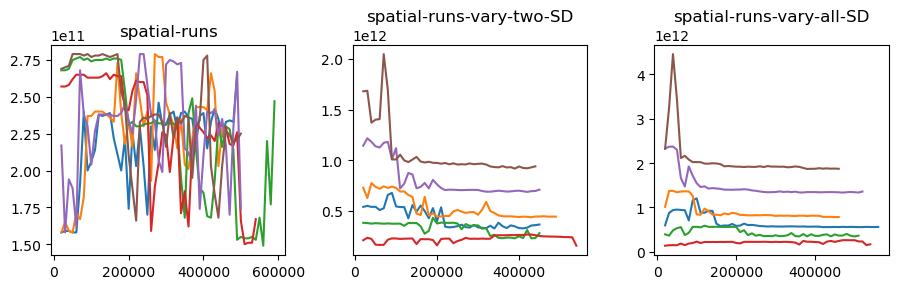

In [6]:
plot_tick_times(INFO)

In [7]:
RUN_STATS = pd.DataFrame(RunStats(info) for infos in INFO.values() for info in infos)
PARAMS = pd.DataFrame(
    [
        {"name": info.name, **info.params, "filename": info.filename}
        for infos in INFO.values()
        for info in infos
    ]
)
RUN_STATS = RUN_STATS.join(
    PARAMS.set_index(["name", "filename"]), on=["name", "filename"]
)

In [8]:
def plot_stat(stats, x, y, unit, **plot_kwargs):
    num_runs = len(stats.name.drop_duplicates())
    fig, axes = plt.subplots(1, num_runs, figsize=(3 * num_runs, 4.5), sharey=True)
    fig.suptitle(y)
    for i, (ax, (name, df)) in enumerate(zip(axes, stats.groupby("name"))):
        if unit == "seconds":
            df.set_index(x).sort_index()[y].dt.total_seconds().plot(
                ax=ax, **plot_kwargs
            )
        elif unit == "minutes":
            (df.set_index(x).sort_index()[y].dt.total_seconds() / 60).plot(
                ax=ax, **plot_kwargs
            )
        elif unit == "hours":
            (df.set_index(x).sort_index()[y].dt.total_seconds() / 60 / 60).plot(
                ax=ax, **plot_kwargs
            )
        else:
            raise ValueError
        ax.set_title(name)
    axes[0].set_ylabel(f"Time ({unit})")
    fig.tight_layout()

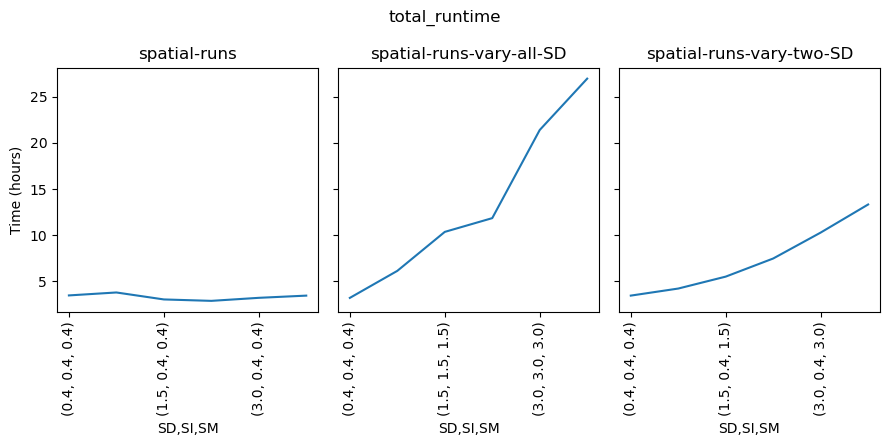

In [9]:
plot_stat(RUN_STATS, ["SD", "SI", "SM"], "total_runtime", "hours", rot=90)

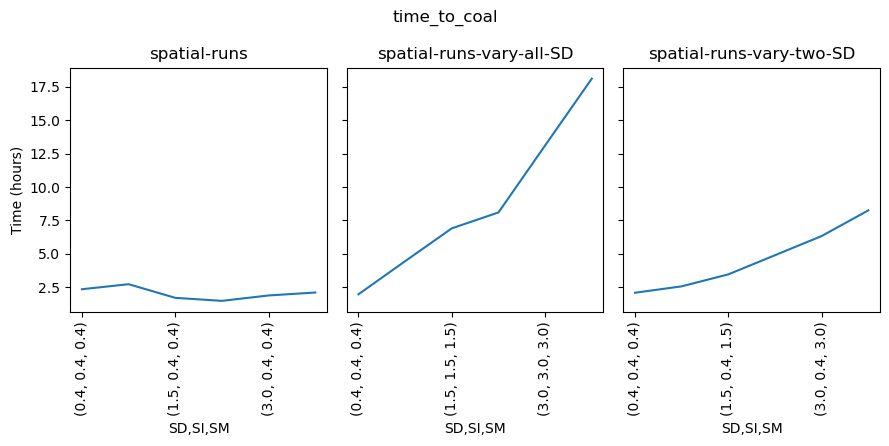

In [10]:
plot_stat(RUN_STATS, ["SD", "SI", "SM"], "time_to_coal", "hours", rot=90)

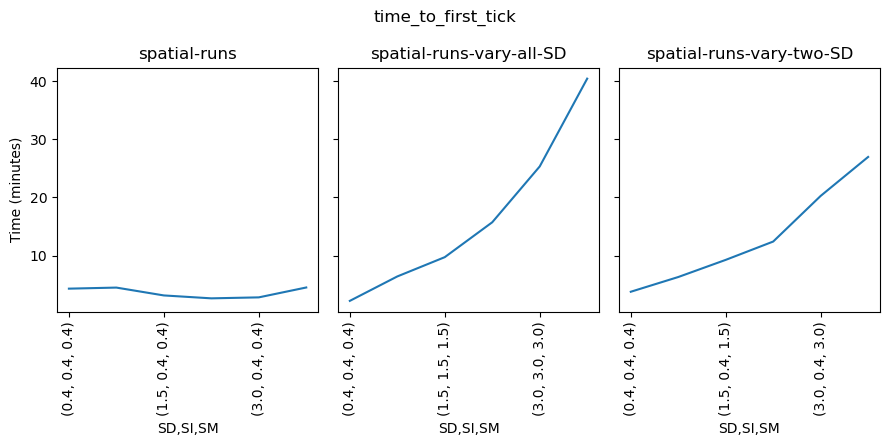

In [11]:
plot_stat(RUN_STATS, ["SD", "SI", "SM"], "time_to_first_tick", "minutes", rot=90)

In [12]:
RUN_STATS.groupby(["SD", "SI", "SM"]).coal_tick.value_counts().reset_index()

,SD,SI,SM,coal_tick,count
0,0.4,0.4,0.4,350000,3
1,1.0,0.4,0.4,400000,1
2,1.0,0.4,1.0,250000,1
3,1.0,1.0,1.0,350000,1
4,1.5,0.4,0.4,300000,1
5,1.5,0.4,1.5,250000,1
6,1.5,1.5,1.5,350000,1
7,2.0,0.4,0.4,250000,1
8,2.0,0.4,2.0,300000,1
9,2.0,2.0,2.0,300000,1


In [13]:
RUN_STATS.columns

Index(['name', 'total_runtime', 'time_to_first_tick', 'time_to_coal',
       'tick_time_avg', 'tick_time_stdev', 'coal_tick', 'filename', 'G',
       'IND_RECORD_FREQ', 'IND_RECORD_LAG', 'IND_RECORD_LIM', 'K', 'L', 'MU',
       'OUTPATH', 'R', 'SD', 'SEED', 'SI', 'SIM_END', 'SM', 'W'],
      dtype='object')